In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

plt.style.use('seaborn-v0_8-whitegrid')
import scipy.stats as ss
from statsmodels.tsa.stattools import acf
import statsmodels.api as sm

from arch import arch_model
from scipy.optimize import minimize 
from scipy.stats import t
from scipy.stats.distributions import t


In [246]:
def qqplot(x, dist="norm"):
    fig, ax = plt.subplots(1,1)
    t, o = ss.probplot(x, dist=dist, plot=ax)
    
    if isinstance(dist, str):
        title = f"{dist.title()} Q-Q Plot"
    else:
        title = f"{dist.dist.name.title()} Q-Q Plot"
        
    
    min_ = min(t[0])
    max_ = max(t[0])
    
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Sample Quantiles')
    ax.set_title(title)

    ax.scatter(t[0],t[1])
    ax.plot((min_, min_), (max_,max_))

def plot_acf_graphs(x: pd.Series, title: str):
    fig, axs = plt.subplots(2,1)
    ax1, ax2 = axs

    ax1.set_title(title)
    ax1.set_ylabel(title)
    ax1.plot(x, c='b')

    ax2.set_ylabel('ACF')
    ax2.set_xlabel('Lag')

    sm.graphics.tsa.plot_acf(x, ax=ax2, lags=50, title=None, auto_ylims=True, c='orange')


    
def get_linspace(data, num_stdevs=5, points=1001):
    """
    Return linspace of the data by calculating (mu-num_stdevs*std, mu+num_stdevs*std)
    """
    mean = np.mean(data)
    stdev = np.std(data)

    linspace = np.linspace(mean - num_stdevs*stdev, mean + num_stdevs*stdev, points)

    return linspace

def es_n(loss: np.ndarray, var: float):
    """
    Calculate expected shortfall.
    Takes array of length n, and calculates avg(loss) given loss[0:n]>var

    :param loss: array of n observations, previous loss 
    :param var: Value at Risk
    """
    # check if loss[0 to n inclusive] > var
    breach_mask = loss>var
    if not breach_mask.sum():
        # return = for no breaches
        return 0
    return loss[breach_mask].sum() / breach_mask.sum()



In [247]:
def get_q2_data():
    df =pd.read_csv('../data/QRM-2022-cw2-data.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=True)
    df.set_index('Date')
    df['logreturn'] = np.log(1 + df['TSLA'].pct_change())
    df['loss'] = -100*df['logreturn']
    df['max_loss'] = df['loss'].apply(lambda x: np.max([x,0]))
    df = df.iloc[1:,:]
    return df.set_index('Date')

df = get_q2_data()

In [248]:
train_mask = df.index < pd.to_datetime('26-11-2021', format='%d-%m-%Y')
train_df = df[train_mask]
test_df = df[~train_mask]

# 1i)

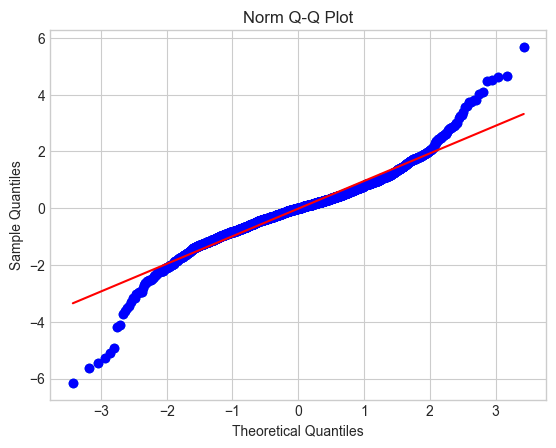

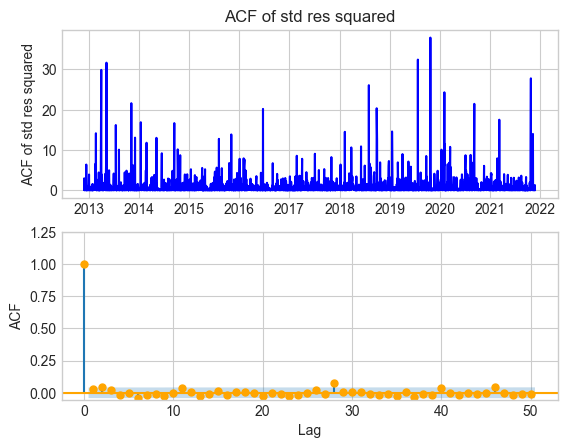

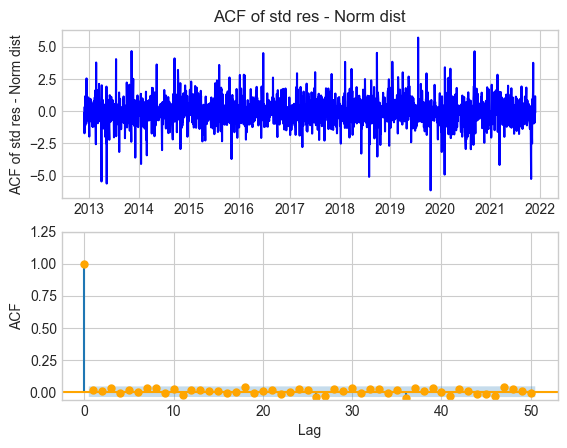

In [249]:

model = arch_model(train_df['loss'],
                    mean='constant', 
                    vol='GARCH', 
                    p=1, q=1, rescale=True, dist='normal')
model_fit_norm = model.fit(update_freq=-1, disp=0)
qqplot(model_fit_norm.std_resid, dist='norm'); plt.show()
plot_acf_graphs(model_fit_norm.std_resid**2, 'ACF of std res squared'); plt.show()
plot_acf_graphs(model_fit_norm.std_resid, 'ACF of std res - Norm dist'); plt.show()


# 1ii)

3.560147359752372 -0.014173871257913296 0.6858888680637825


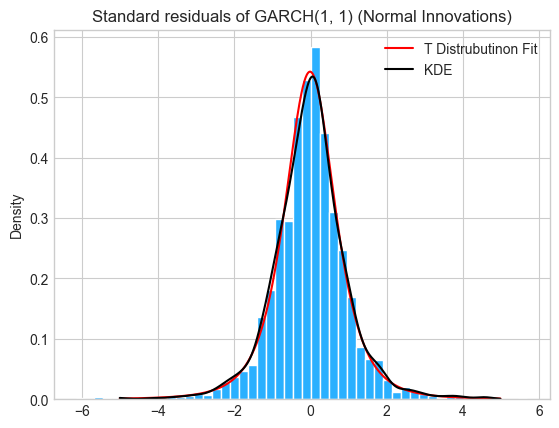

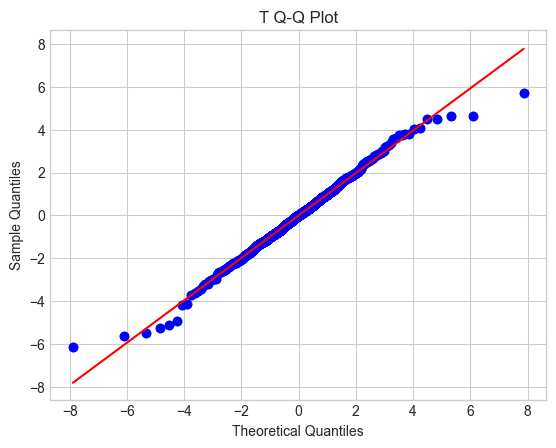

In [250]:
# fit t dist to residules 
dof, loc, scale = t.fit(model_fit_norm.std_resid,)
print(dof, loc, scale)
t_dist_fit=t(df=dof, loc=loc, scale=scale)


x = get_linspace(model_fit_norm.std_resid)
kde = ss.gaussian_kde(model_fit_norm.std_resid)
t_dist_fit_pdf = t_dist_fit.pdf(x)


plt.plot(x, t_dist_fit_pdf, label= 'T Distrubutinon Fit', color='red');
plt.plot(x, kde(x), label='KDE', color='k');
plt.hist(model_fit_norm.std_resid, bins=50, density=True,facecolor='#2ab0ff', edgecolor='white');
plt.ylabel('Density')
plt.title("Standard residuals of GARCH(1, 1) (Normal Innovations)"); plt.legend(); plt.show()

qqplot(model_fit_norm.std_resid, dist=t_dist_fit); plt.show()


### Experimental after here

In [251]:
# get model fit params

mu = model_fit_norm.params['mu']
alpha_0 = model_fit_norm.params['omega']
alpha_1 = model_fit_norm.params['alpha[1]']
beta_1 = model_fit_norm.params['beta[1]']
print(mu, alpha_0, alpha_1, beta_1)


-0.1506096273719729 0.13901461211044847 0.04094424129773367 0.9482207390008065


In [252]:
# use params to forecast var for both in and out of sample

var = np.zeros_like(df['loss'].dropna())
var[0] = np.var(df['loss'].dropna(), ddof=1) # sample variance

# below is from model_fit_norm.conditional_volatility[0] (using the same starting point as the fitted model)
var[0]=1.833599**2


# Iteration over the GARCH(1,1) dynamics
for i in range(1, len(df['loss'].dropna())):
    var[i] = alpha_0 + alpha_1*(df['loss'].dropna()[i-1] - mu)**2 + (beta_1) * var[i-1]


## Open Question:
### *How to get Z quantile values for generating VaR and ES*

#### For initial forecast
- Use the standard normal / standard t dist Z value for p=0.95/0.99 one tail
- Use the fitted model standardised residules to find empirical quantile  

#### For ongoing forecasts
In CW1 we refitted the model on a rolling basis, and used the standardised residules to compute the quantile.
- Use the standard normal / standard t dist Z value for p=0.95/0.99 one tail (fixed)
- Use the fitted model standardised residuals to find empirical quantile (fixed)
- Use the Historical Simulation method (part 2, slide 55) (rolling/ expanding)


In [263]:
mu

-0.1506096273719729

In [253]:

z_95 = np.quantile(model_fit_norm.std_resid, 0.95)
z_99 = np.quantile(model_fit_norm.std_resid, 0.99)

df['std_forc'] = var**0.5


# df['95_var'] = mu+z_95*df['std_forc']
# df['99_var'] = mu+z_99*df['std_forc']


In [254]:
#  std resid using each days std forecast (z_t = (x_t - mu)/std_forc )
df['z_t'] = (df['loss']-mu)/df['std_forc']


df['q_95'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.95)).shift(1)
df['q_99'] = df['z_t'].rolling(500).apply(lambda x: np.quantile(x,0.99)).shift(1)


df['var_95'] = mu+df['q_95']*df['std_forc']
df['var_99'] = mu+df['q_99']*df['std_forc']


In [272]:
df[~train_mask].head()

,TSLA,logreturn,loss,max_loss,std_forc,z_t,q_95,q_99,var_95,var_99
Date,,,,,,,,,,
2021-11-26,360.640015,-0.031014,3.101358,3.101358,3.766584,0.863373,1.448838,2.617838,5.306560,9.709698
2021-11-29,378.996674,0.049647,-4.964716,0.000000,3.744939,-1.285497,1.448838,2.617838,5.275199,9.653034
2021-11-30,381.586670,0.006811,-0.681058,0.000000,3.792928,-0.139852,1.448838,2.617838,5.344729,9.778664
2021-12-01,365.000000,-0.044441,4.444065,4.444065,3.713749,1.237207,1.448838,2.617838,5.230010,9.571384
2021-12-02,361.533325,-0.009543,0.954313,0.954313,3.752490,0.294451,1.448838,2.617838,5.286140,9.672803


In [275]:
df['2021-11-24':].iloc[0, 4]

3.847789324358837

In [260]:

print('train only')
a = df[train_mask]['loss']>df[train_mask]['var_95']
b = (df[train_mask]['loss']>df[train_mask]['var_99'])
print(f"{a.mean():.4f}. {a.sum()}")
print(f"{b.mean():.4f}. {b.sum()}")



print('\n\ntest only')
a = df[~train_mask]['loss']>df[~train_mask]['var_95']
b = (df[~train_mask]['loss']>df[~train_mask]['var_99'])
print(f"{a.mean():.4f}. {a.sum()}")
print(f"{b.mean():.4f}. {b.sum()}")


print('\nall')
a = df['loss']>df['var_95']
b = (df['loss']>df['var_99'])
print(f"{a.mean():.4f}. {a.sum()}")
print(f"{b.mean():.4f}. {b.sum()}")


# 99 var quite accurate
# 95 var not good, 2x num of expected breaches


train only
0.0406. 92
0.0084. 19


test only
0.0992. 25
0.0159. 4

all
0.0465. 117
0.0091. 23


In [265]:
mask = df[~train_mask]['loss']>df[~train_mask]['var_95']
df[~train_mask][mask].loc['2022-04-20']

TSLA         325.733337
logreturn     -0.050825
loss           5.082502
max_loss       5.082502
std_forc       3.656743
z_t            1.431085
q_95           1.430639
q_99           2.039143
var_95         5.080870
var_99         7.306014
Name: 2022-04-20 00:00:00, dtype: float64

KeyError: "['99_var', '95_var'] not in index"

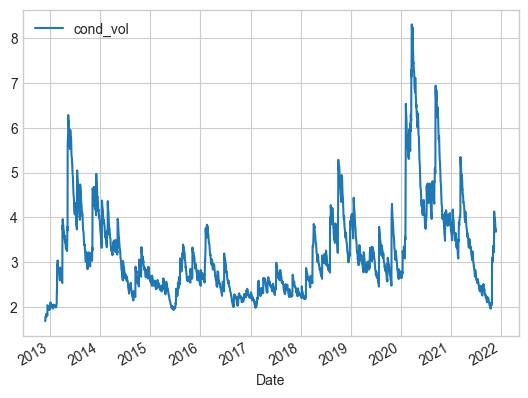

In [256]:
mu = model_fit_norm.params.mu 
ax = (mu+model_fit_norm.conditional_volatility).plot(zorder=20, legend=True)
ax = df[['99_var','95_var','max_loss']].plot(ax=ax); plt.show()

In [268]:
a=df.reset_index()
a['Date'][10-3:10]

7   2012-12-06
8   2012-12-07
9   2012-12-10
Name: Date, dtype: datetime64[ns]

In [ ]:
# verify that the gaarch model fit is the same as the manually constructed line
ax=(df['pred_variance']**0.5).plot(alpha=0.5, label='home cooked', legend=True)
ax = (model_fit_norm.conditional_volatility).plot(ax=ax, zorder=-10, alpha=0.5, linestyle='-', linewidth=3, label='arch package insample', legend=True)
plt.show()